# ___

# [ Machine Learning in Geosciences ]



Lecturer: *Lukas Brodsky lukas.brodsky@natur.cuni.cz*

**Department of Applied Geoinformatics and Carthography, Charles University** 

___

## GeoPandas & Rasterio

This notebook demonstrates how to combine vectors and rasters in Python workflow. 

## Rasterizing poylgons

In [1]:
import os 
import geopandas as gpd 
import rasterio as rio
from rasterio import features
import numpy as np 

import matplotlib.pyplot as plt 
%matplotlib inline

In [4]:
# Reading vector 
# CHANGE TO YOUR PATH!!!
path = r'C:\Users\uzivatel\Documents\GitHub\Machine_learning\10_11_LAB_GeoAI_GeoPython\GeoPython'
filename = 'polygons.shp'
path_fn_vec = os.path.join(path, filename)
gdf = gpd.read_file(path_fn_vec)

In [5]:
gdf.head()

,label,note,geometry
0,1,glacier,"POLYGON ((630019.737 7747367.105, 630896.053 7..."
1,2,debries,"POLYGON ((631944.079 7740883.553, 632169.079 7..."
2,3,rock,"POLYGON ((625330.263 7741517.105, 625780.263 7..."


In [6]:
geometry = gdf['geometry'] 

In [7]:
geometry

0    POLYGON ((630019.737 7747367.105, 630896.053 7...
1    POLYGON ((631944.079 7740883.553, 632169.079 7...
2    POLYGON ((625330.263 7741517.105, 625780.263 7...
Name: geometry, dtype: geometry

In [8]:
# Reading example raster 
raster_filename = 'landsat.tif' 
path_fn_ras = os.path.join(path, raster_filename)
ds = rio.open(path_fn_ras)
ds

<open DatasetReader name='C:/Users/uzivatel/Documents/GitHub/Machine_learning/10_11_LAB_GeoAI_GeoPython/GeoPython/landsat.tif' mode='r'>

In [9]:
# Raster file metadata 
meta = ds.meta
print(type(meta))
print('Metadata od the dataset: ...')
for k in meta:
    print(k, meta[k])

<class 'dict'>
Metadata od the dataset: ...
driver GTiff
dtype int16
nodata None
width 500
height 500
count 6
crs PROJCS["WGS 84 / UTM zone 21N",GEOGCS["WGS 84",DATUM["World Geodetic System 1984",SPHEROID["WGS 84",6378137,298.257223563]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",-57],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]
transform | 30.00, 0.00, 624000.00|
| 0.00,-30.00, 7750000.00|
| 0.00, 0.00, 1.00|


In [10]:
meta['width']

500

In [11]:
meta['count'] = 1

In [12]:
meta

{'driver': 'GTiff',
 'dtype': 'int16',
 'nodata': None,
 'width': 500,
 'height': 500,
 'count': 1,
 'crs': CRS.from_wkt('PROJCS["WGS 84 / UTM zone 21N",GEOGCS["WGS 84",DATUM["World Geodetic System 1984",SPHEROID["WGS 84",6378137,298.257223563]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",-57],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]'),
 'transform': Affine(30.0, 0.0, 624000.0,
        0.0, -30.0, 7750000.0)}

In [13]:
# out filename 
out_fn_ras = os.path.join(path, 'rasterized_poly.tif')

In [14]:
# write the raster 
with rio.open(out_fn_ras, 'w+', **meta) as out:
    out_arr = out.read(1)

    # this is where we create a generator of geom, value pairs to use in rasterizing
    shapes = ((geom, value) for geom, value in zip(gdf.geometry, gdf.label))

    burned = features.rasterize(shapes=shapes, fill=0, out=out_arr, transform=out.transform)
    out.write_band(1, burned)


In [15]:
os.path.isfile(out_fn_ras)

True

In [16]:
# Check the rasterization! 
rio_ds = rio.open(out_fn_ras)
rio_arr = rio_ds.read(1)
rio_arr.shape

(500, 500)

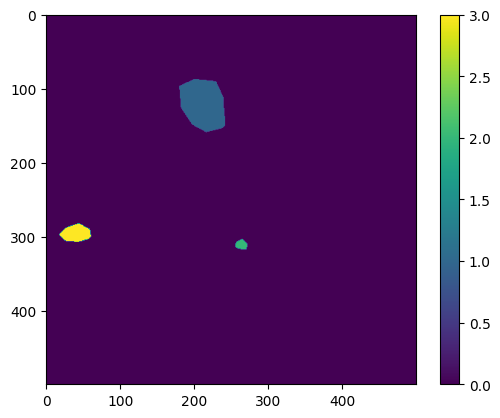

In [17]:
plt.imshow(rio_arr)
plt.colorbar()

In [18]:
np.unique(rio_arr)

array([0, 1, 2, 3], dtype=int16)

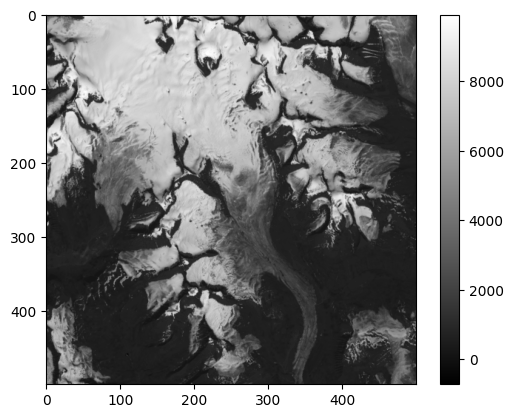

In [19]:
B1 = ds.read(1)
plt.imshow(B1, cmap='gray')
plt.colorbar()

### Raster Vector overlay 


In [20]:
# bands
ds.indexes

(1, 2, 3, 4, 5, 6)

In [21]:
image_arr = np.dstack([ds.read(b) for b in ds.indexes])

In [22]:
image_arr.shape

(500, 500, 6)

In [23]:
rio_arr.shape 

(500, 500)

In [24]:
image_arr.shape

(500, 500, 6)

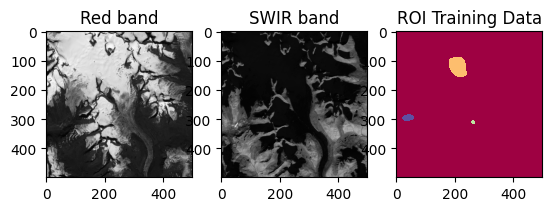

In [25]:
# Display them
plt.subplot(131)
plt.imshow(image_arr[:, :, 2], cmap=plt.cm.Greys_r)
plt.title('Red band')

plt.subplot(132)
plt.imshow(image_arr[:, :, 5], cmap=plt.cm.Greys_r)
plt.title('SWIR band')

plt.subplot(133)
plt.imshow(rio_arr, cmap=plt.cm.Spectral, interpolation='nearest')
plt.title('ROI Training Data')

plt.show()

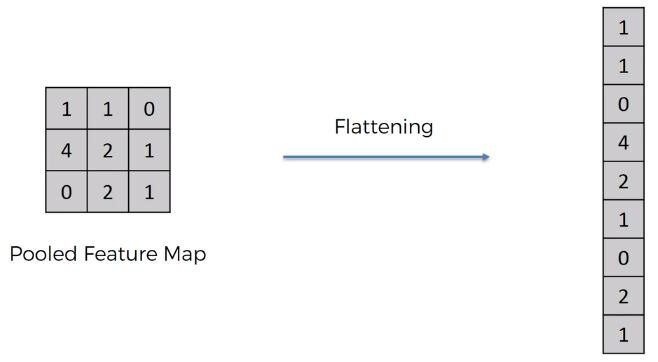

In [26]:
rio_arr.shape

(500, 500)

In [27]:
flattened_rio = rio_arr[rio_arr > 0]
flattened_rio.shape

(4370,)

In [28]:
image_arr[rio_arr > 0, :].shape

(4370, 6)

In [29]:
# my data for Machine Learning 
X = image_arr[rio_arr > 0, :] 
y = rio_arr[rio_arr > 0]

In [ ]:
# X.shape

In [30]:
print('Our X matrix is sized: {sz}'.format(sz=X.shape))
print('Our y array is sized: {sz}'.format(sz=y.shape))

Our X matrix is sized: (4370, 6)
Our y array is sized: (4370,)
